In [1]:
#this is a data cleaning jupyter notebook on horse racing data

import pandas as pd
import numpy as np
import regex as re
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import math
%pwd

'/home/neilfa/jupyter_data_cleaning'

In [2]:
with open('/proc/meminfo') as file:
    for line in file:
        if 'MemFree' in line:
            free_mem_in_kb = line.split()[1]
            break
file_path = '2019_1_1-2020_1_1.csv' 
file_size = os.path.getsize(file_path)
            
start = time.time()
df = pd.read_csv(file_path)
end = time.time()
index = df.index
num_row = len(index)

print('It takes {0} seconds to load in {1} rows of data (size of the file is {2} bytes), with {3} memory available'.format((end-start),num_row,file_size,free_mem_in_kb))

It takes 0.18025708198547363 seconds to load in 31651 rows of data (size of the file is 14016826 bytes), with 10408216 memory available


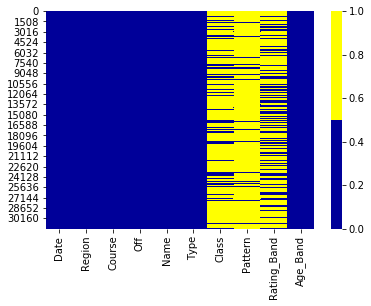

In [3]:
#This is chart looks at the nan counts
#The Class column is mostly empty
# missing values analysis

cols = df.columns[:10] # first 30
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#normal for class to have missing values as Ireland races don't have a class



In [4]:
# Gonna make a smaller dataframe (sm_df)
# Just to make it easier to work with

sm_df = df.loc[:,('Date','Off','Name','Horse','Pos','SP','Ran','Time','RPR','Prize','Class')]

sm_df.head()

,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Prize,Class
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,3/1,15,5:1.80,127.0,€8008,NaN
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,8/1,15,5:4.20,111.0,€2483,NaN
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,10/11F,15,5:5.15,115.0,€1183,NaN
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,25/1,15,5:5.40,112.0,€533,NaN
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,8/1,15,5:5.70,111.0,€208,NaN


In [7]:
grpDN = sm_df.groupby(['Date','Off','Name']) 
grpN = sm_df.groupby(['Name'])
print("there are {} races with the same name and on the same day \ntotal number of races is {} in 2019".format((grpDN.ngroups-grpN.ngroups),grpDN.ngroups))


there are 406 races with the same name and on the same day 
total number of races is 2677 in 2019


In [8]:
#Creating a Unique ID for each race (UID)
#year(2019) + the index number (could be alphabetical), the name is not important as long as each race has a UID

UID = list()
racesnu = grpDN.ngroups
for i in range(racesnu):
    UID.append('2019'+(str(i+1)))

#append value to a already excisting key
#https://thispointer.com/python-how-to-add-append-key-value-pairs-in-dictionary-using-dict-update/#:~:text=this'%3A%2043%7D-,Append%20multiple%20key%20value%20pair%20in%20dictionary,it%20will%20update%20its%20value.
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value    



#If you look at the pattern of 'Ran' (number of horses in a race)
#it looks something like 3,3,3,4,4,4,4,2,2
#if I turn that list into 3,4,2 , Ie  first race 3 ran 2nd race 4 ran etc
#Then i can create a list that goes like:
    #repeat UID 3 times then repeat the next UID 4 times etc

lsRan = list(sm_df['Ran'])

for i, x in enumerate(lsRan):
    del lsRan[i+1:i+x]

#the loop below confirms that there is in fact 2677 not 2663
cnt =0 
test = dict(sm_df['Ran'].value_counts())
for keys in test:
    cnt += (test[keys]/keys)

lsUID = [] #list of all the UIDs that can go in the dataframe
for i in range(len(UID)):
    lc = [UID[i]]*lsRan[i]
    for j in lc:
        lsUID.append(j)
sm_df['UID']=lsUID

#Now each race a UID



In [13]:
#The prize column is a string because of the euro sign
#Moreover im creating a new column called '1stPrize'
#This will only contain the prize money for coming 1st in each race
#This will me to find the correlation between 1stPrize and the Class

races = sm_df.groupby('UID').groups #keys each UID, value is the indexes containing each race.
#for eg. the first race contains 15 horses, so the indexes for the first UID is range(0,14)

Races = sm_df.loc[:,'UID'].unique()

nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['1stPrize']= nas[0] #empty colmun




for i in Races:
    #Sorting out prize money in this loop
    index = races[i]
    ln = len(index)
    money = sm_df.loc[index[0],'Prize']
    fmon = float(re.findall(r'\d+',money)[0])#extracting the number from the euro sign
    sm_df.loc[index,'1stPrize']= [fmon]*ln
    
    



In [14]:
racegrp = sm_df.groupby(['Class'])
racegrp.mean()

#If you look at the column Prize you will see that in general the class is correlated with 1stPrize money
#However theres a lack in correlation after class 4
#So when I'm going to treat class 5,6,7 as one class

,Ran,RPR,1stPrize
Class,,,
Class 1,10.927339,110.304858,59065.139817
Class 2,12.304348,112.351852,18741.014493
Class 3,15.439024,106.063107,12980.008130
Class 4,14.412099,86.483840,8288.361754
Class 5,15.142061,76.615322,6518.004875
Class 6,8.000000,97.000000,7387.000000
Class 7,12.055556,93.060606,6844.444444


In [15]:
#This is a Class  vs Prize analysis
#Code get's a bit complicated here
#I just wanted to find the upper and lower quartile range of prize money for each class
#Then I will use that as my guide to allocate a class to the races that dont have a class.
#The output of this cell will show the quartiles

c1=[]
c2=[]
c3=[]
c4=[]
c5=[]
c6=[]
c7=[]
test=[]
clT = sm_df.loc[sm_df['Class'].notnull()]
#for i in Races:
 #   s
for i in Races:
    index = races[i]
    in1 = index[0]
    st1 = sm_df.loc[in1,'1stPrize']
    
    if sm_df.loc[in1,'Class'] == "Class 1":
        c1.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 2":
        c2.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 3":
        c3.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 4":
        c4.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 5":
        c5.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 6":
        c6.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 7":
        c7.append(st1)
    else:
        test.append(st1)

dict1 = {'c1':c1,'c2':c2,'c3':c3,'c4':c4,'c5':c5,'c6':c6,'c7':c7,'test':test}
        
prizeQ = [] #this is just a a place that a place where I can keep all of the quartiles

for i in dict1:
    values = sorted(dict1[i])
   # print(values)
    half = round(len(values)/2)
    #print(round(half))
    Q1 = np.median(values[:half])
    Q3 = np.median(values[half:])
    IQR = Q3-Q1
    prizeQ.append(Q3)
    prizeQ.append(Q1)
    print("The winner's prize money in a class {}: Upper Q = {}, Lower Q = {}".format(i,Q3,Q1))
#for some reason the lowerQ for prizeQ comes nan so I will just add an estimated value
#Again doesnt really matter because I'm going to treat class 5,6,7 as one
prizeQ = [6500 if str(x)=='nan' else x for x in prizeQ] 

The winner's prize money in a class c1: Upper Q = 59000.0, Lower Q = 26845.0
The winner's prize money in a class c2: Upper Q = 18450.0, Lower Q = 15340.0
The winner's prize money in a class c3: Upper Q = 11820.0, Lower Q = 10401.0
The winner's prize money in a class c4: Upper Q = 7700.0, Lower Q = 6796.0
The winner's prize money in a class c5: Upper Q = 6468.0, Lower Q = 5910.0
The winner's prize money in a class c6: Upper Q = 7387.0, Lower Q = nan
The winner's prize money in a class c7: Upper Q = 7700.0, Lower Q = 6468.0
The winner's prize money in a class test: Upper Q = 10047.0, Lower Q = 6776.0


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
##PROBLEM HERE,
##THIS is where I need HELP


#Now I've gotten the quartile ranges need to assign classes to the nan classes
#So if prize money is inbetween Q1 or Q3 of let's say class 1 then the class would be class 1 for that nan
#I'm basically now creating 4 new ranges from the quartiles
#Anything that's not in the 4 ranges ie. class 1,2,3,4 will be assigned a class of 5 or 6 or 7 randomly

#I don't actually know how to do this effectively
#I tried doing this for loop but it takes too long and too much computing power
#Need help please

st1 = sm_df.loc[:,('Class','1stPrize')]


#range1(p1) = anything over the half way point of Class 1 Q1 and Class 2 Q3
p1 = int(round((prizeQ[1]+prizeQ[2])/2))#min for class 1
q2 = int(round((prizeQ[3]+prizeQ[4])/2))
#Range2(p2) = anything between the half way point of Class 1 Q1 and Class 2 Q3
#to between the half way point of Class 1 Q1 and Class 2 Q3
p2 = range(q2,p1)
q3 = int(round((prizeQ[5]+prizeQ[6])/2))#range of prize money for class 3
p3 = range(q3,q2) #Range 3 
p4 = range(int(round((prizeQ[7]+prizeQ[8])/2)),q3) #range of prize money for class 4
pz = []
def p2c(x):
    if x>p1:
        return 'Class 1'
    elif x in p2:
        return 'Class 2'
    elif x in p3:
        return 'Class 3'
    elif x in p4:
        return 'Class 4'
    else:
        return 'Class 5'
    
for i in range(st1.shape[0]):
    #print(st1.iloc[i,0])
    if str(st1.iloc[i,0]) != 'nan':# != 'test':
        pz.append(st1.iloc[i,0])
    else:
        pz.append(p2c(st1.iloc[i,1]))